# Zeitreihenanalyse & Trends

## Rückblick und Übergang

In Notebook 05 (Regressionsanalyse) haben wir ein multiples Regressionsmodell erstellt (FeelingSafe ~ Log_Homicides + SocialSupport). Dieses Modell erklärte ca. 49% der Varianz und zeigte uns, welche Faktoren strukturell mit dem Sicherheitsgefühl zusammenhängen.

Das Problem: Die bisherige Analyse basierte auf einer "Momentaufnahme" (Snapshot). Wir haben Länder verglichen, als ob die Zeit stillstehen würde. Aber Gesellschaften verändern sich. Ein Land mit hoher Kriminalität, in dem die Raten jedoch drastisch sinken, fühlt sich für die Einwohner anders an als ein Land, in dem die Raten steigen.

Für Hypothesentests bleiben wir beim Snapshot, für Trends nutzen wir jetzt den **Time-Series-Datensatz**. So vermeiden wir Pseudoreplikation, aber verlieren die Dynamik nicht aus dem Blick.

## Ziel dieses Notebooks

Wir wechseln von der statischen Betrachtung zur dynamischen Betrachtung: als würden wir vom Foto zum Film wechseln. Wir nutzen den Datensatz oecd_full_time_series.csv, um zu untersuchen:

- Visualisierung (VL 2): Wie haben sich unsere Hauptindikatoren (Mordrate, Soziale Unterstützung) über die Jahre entwickelt?

- Trend-Berechnung (VL 10): Können wir mathematisch bestimmen, ob sich die Situation in einem Land systematisch verbessert oder verschlechtert?



Am Ende dieses Notebooks wollen wir aussagen können, ob die Welt im OECD-Raum eher sicherer oder unsicherer geworden ist und warum. 

## Setup & Daten Laden

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
filename = 'oecd_full_time_series.csv'
current_dir = Path.cwd()

# Liste möglicher Speicherorte (Priorität von oben nach unten)
possible_paths = [
    current_dir / filename,                          # Gleicher Ordner
    current_dir / 'data' / filename,                 # Unterordner 'data'
    current_dir.parent / 'data' / filename,          # Parent Ordner -> 'data' (Struktur aus NB 01)
    current_dir.parent / filename                    # Ein Ordner höher
]

df_time = None
found_path = None

for path in possible_paths:
    if path.exists():
        found_path = path
        break

if found_path:
    print(f"Datei gefunden in: {found_path}")
    df_time = pd.read_csv(found_path)
    display(df_time.head())
else:
    print(f"FEHLER: Die Datei '{filename}' wurde nirgends gefunden.")
    print(f"Gesucht wurde in: {[str(p) for p in possible_paths]}")
    print("BITTE PRÜFEN: Wurde Notebook 01 vollständig ausgeführt?")
    # Stoppt die Ausführung hier, damit keine Folgefehler kommen
    sys.exit("Daten fehlen - Abbruch.")

Datei gefunden in: /Users/Flurina/Library/CloudStorage/OneDrive-Persönlich/Documents/Uni_St.Gallen/BCS/3.Semester/Statistik_für_Data_Science/Projekt/Project/Statistik_Projekt_OECDWellBeing/data/oecd_full_time_series.csv


,reference_area,measure,unit_of_measure,age,sex,education_level,domain,year,value
0,Spain,Employment rate,Percentage of population aged 25-64 years in t...,Young,Total,Total,Work and job quality,2004,38.544000
1,Portugal,Long-term unemployment rate,Percentage of labour force in the same subgroup,Total,Male,Total,Work and job quality,2004,2.707735
2,Iceland,Employment rate,Percentage of population aged 25-64 years in t...,Middle-aged,Total,Total,Work and job quality,2004,86.765000
3,Greece,Employment rate,Percentage of population aged 25-64 years in t...,Total,Total,Primary education,Work and job quality,2004,57.986698
4,France,"Youth not in employment, education or training",Percentage of population aged 15-24 years in t...,Total,Female,Total,Work and job quality,2004,12.691035


## Methodik: Was wir tun – und was wir NICHT tun

**Was wir anwenden: Lineare Trendschätzung (OLS)**

Wir werden für jedes Land eine einfache lineare Regression über die Zeit berechnen.

- Formel: Y = β0 + β₁ ⋅ Jahr + ϵ

- Warum? Unser Ziel ist es, die grundsätzliche Richtung (Trend) zu erkennen. Steigt die Kurve oder fällt sie? Der Koeffizient β₁ (die Steigung) gibt uns genau diese Information:

  - β₁ > 0: Der Wert steigt über die Jahre.
  - β₁ < 0: Der Wert sinkt über die Jahre.

- Dies ist eine einfache und für unsere kurzen Zeitreihen gut geeignete Methode, um die grundsätzliche Entwicklungsrichtung zu bestimmen.

Dabei setzen wir eine annähernd lineare Entwicklung über die Zeit voraus. Das bedeutet: Wir fassen alle verfügbaren Jahreswerte so zusammen, dass wir einen durchschnittlichen Trend erhalten. Bei Ländern mit starken Strukturbrüchen oder Ausreißerjahren beschreibt die Gerade daher den groben Mitteltrend, nicht jede einzelne jährliche Schwankung.

**Was wir NICHT anwenden (und warum)**

Obwohl es fortgeschrittene Methoden der Zeitreihenanalyse gibt, verzichten wir bewusst auf folgende Verfahren:

- Saisonale Zerlegung (Seasonality Decomposition):
  - Erklärung: Zerlegung einer Kurve in Trend, Saisonalität (z.B. Weihnachten) und Rauschen.
  - Grund für Ausschluss: Unsere Daten sind Jahresdaten. Saisonalität (monatliche Schwankungen) existiert in dieser Auflösung nicht.

- ARIMA / SARIMA (Forecasting):
  - Erklärung: Komplexe Modelle zur Vorhersage der Zukunft.
  - Grund für Ausschluss: Die Zeitreihen pro Land sind oft zu kurz (wenige Jahre) und haben Lücken. Für robuste ARIMA-Modelle bräuchte man deutlich mehr Datenpunkte (oft >50). Zudem ist unser Ziel deskriptiv (Verstehen der Vergangenheit), nicht prädiktiv (Vorhersage von 2030).




## Datenvorbereitung für Zeitreihen

Zeitreihenanalysen sind anfällig für fehlende Daten. Ein Land, das nur einen einzigen Datenpunkt im Jahr 2020 hat, kann keinen "Trend" haben. Wir müssen prüfen, wie viele Datenpunkte wir pro Land haben.

Wir konzentrieren uns auf unsere im letzten Notebook identifizierten Schlüsselvariablen. Da die Spaltennamen in Notebook 01 bereinigt ("gesluggified") wurden (z.B. Kleinschreibung, Unterstriche), passen wir den Filter hier an:

- Homicide rate (in NB 01 wahrscheinlich als homicide_rate oder ähnlich gespeichert, wir prüfen gleich die Spalte measure)
- Social support (wahrscheinlich social_support)

*Hinweis zur Skala:* 
In Notebook 05 haben wir die Mordrate logarithmiert (Log_Homicides), um Ausreißer und starke Schiefe zu dämpfen. Für die Zeitreihenanalyse verwenden wir bewusst die Originalskala, weil wir hier nicht p-Werte oder exakte Modellpassformen benötigen, sondern vor allem die Richtung (steigt/sinkt) der Veränderung. Die Interpretation „Morde pro 100.000 Einwohner nehmen zu/ab“ bleibt so besonders anschaulich.

*Hinweis zur Mindestanzahl an Jahren:*
Für die Trendanalyse benötigen wir mindestens drei Jahreswerte pro Land.
Mit nur zwei Punkten lässt sich zwar formal eine Gerade legen, sie verbindet aber lediglich zwei Werte und bildet keinen stabilen Trend. Erst ab drei Beobachtungen kann die Regression eine sinnvolle Richtung (steigend/sinkend) extrahieren und einzelne Ausreißerjahre relativieren.

*Hinweis:* 
Wir filtern auf die Spalte 'measure', müssen aber prüfen, wie die Werte dort genau heißen.

In [4]:
# Wir filtern auf die Indikatoren, die unsere Hauptthemen "Sicherheit" und "Gesellschaft" repräsentieren.
# Homicide rate = Objektive Sicherheit (Proxy für Feeling Safe, da Feeling Safe oft nicht jährlich erhoben wird)
# Social support = Soziale Resilienz

# Wir suchen flexibel nach den Namen im Datensatz (case-insensitive)
all_measures = df_time['measure'].unique()
print("Verfügbare Measures (Auszug):", all_measures[:5])

# Suche nach den korrekten Bezeichnungen
homicide_name = next((m for m in all_measures if "omicide" in m), None)
social_name = next((m for m in all_measures if "ocial" in m), None)

target_measures = [m for m in [homicide_name, social_name] if m is not None]

# Filtern
df_ts_filtered = df_time[df_time['measure'].isin(target_measures)].copy()

print(f"\nAnalysierte Indikatoren: {target_measures}")
print(f"Anzahl der Beobachtungen: {len(df_ts_filtered)}")

Verfügbare Measures (Auszug): ['Employment rate' 'Long-term unemployment rate'
 'Youth not in employment, education or training'
 'Deaths from suicide, alcohol, drugs' 'Long hours in paid work']

Analysierte Indikatoren: ['Homicides', 'Time spent in social interactions']
Anzahl der Beobachtungen: 2487


## Visualisierung (Qualitativ)

Gemäß Vorlesung 2 ("Effective Visualization") ist das Liniendiagramm das Mittel der Wahl für zeitliche Verläufe, da es Veränderungen intuitiv als Bewegung von links nach rechts darstellt.

*Herausforderung:* Wir haben über 30 Länder. Alle in eine Grafik zu plotten ("Spaghetti-Plot"), würde zu Unleserlichkeit führen. Lösung: Wir wählen exemplarisch 5 Länder aus verschiedenen Regionen/Clustern aus, um die Bandbreite der Entwicklungen zu zeigen.

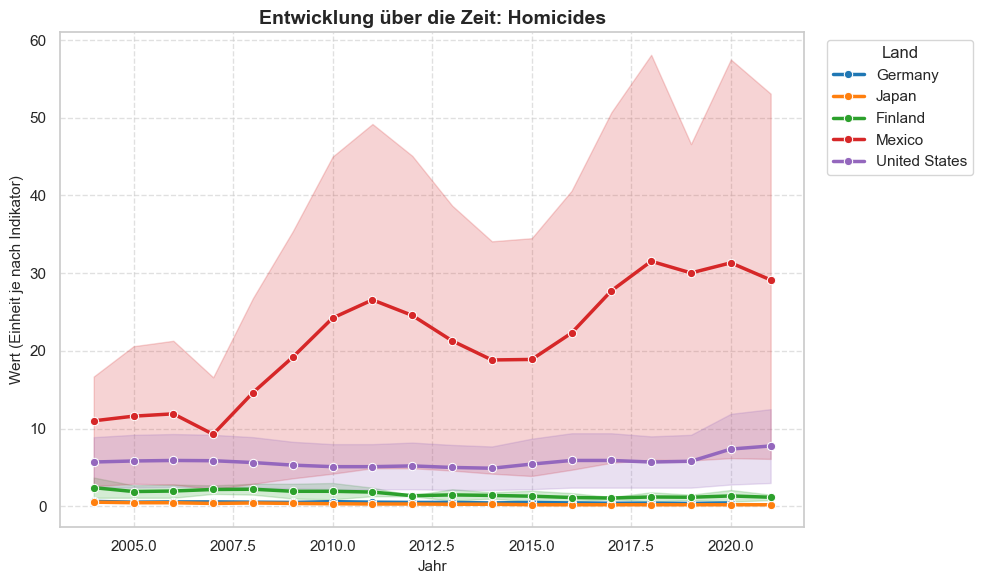

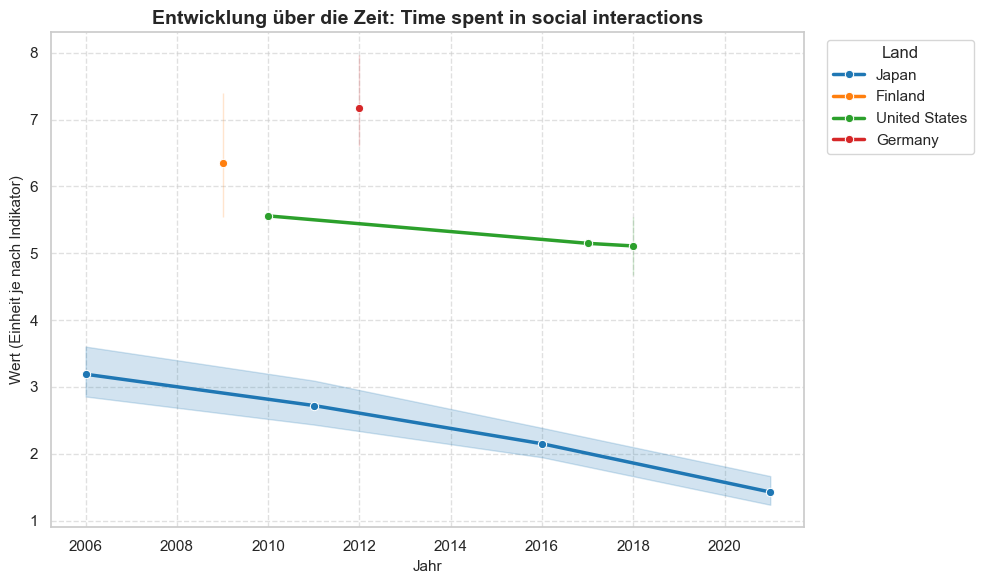

In [5]:
def plot_time_series(indicator_name, countries_to_plot):
    """
    Erstellt ein sauberes Liniendiagramm gemäß VL2-Prinzipien.
    """
    # Daten filtern
    subset = df_ts_filtered[
        (df_ts_filtered['measure'] == indicator_name) & 
        (df_ts_filtered['reference_area'].isin(countries_to_plot))
    ].sort_values('year')
    
    if subset.empty:
        print(f"Keine Daten für {indicator_name} und die gewählten Länder.")
        return

    plt.figure(figsize=(10, 6))
    
    # Plotten mit Markern für jeden Datenpunkt (zeigt Datendichte)
    sns.lineplot(data=subset, x="year", y="value", hue="reference_area", 
                 marker="o", linewidth=2.5, palette="tab10")
    
    plt.title(f"Entwicklung über die Zeit: {indicator_name}", fontsize=14, fontweight='bold')
    plt.ylabel("Wert (Einheit je nach Indikator)", fontsize=11)
    plt.xlabel("Jahr", fontsize=11)
    plt.legend(title="Land", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6) # Hilfslinien für bessere Lesbarkeit
    plt.tight_layout()
    plt.show()

# Wir wählen Länder, die wir auch in NB 04/05 betrachtet haben oder die interessant sind
# Bitte sicherstellen, dass diese Namen exakt so in der Spalte 'reference_area' vorkommen
sample_countries = ['Germany', 'United States', 'Mexico', 'Finland', 'Japan']

# Plots generieren
if homicide_name:
    plot_time_series(homicide_name, sample_countries)

if social_name:
    plot_time_series(social_name, sample_countries)

### Interpretation

Bevor wir Trends berechnen, lohnt sich ein Blick auf die reinen Verläufe. Die beiden Plots zeigen sehr gut, wie unterschiedlich sich die Länder über die Jahre entwickeln.

#### Homicides (Tötungsdelikte pro 100.000 Einwohner)
Im ersten Plot fällt sofort auf, wie stark sich die Länder im Niveau unterscheiden:

- **Mexiko** liegt deutlich über allen anderen Ländern und zeigt über die Jahre hinweg ein eher **schwankendes, aber insgesamt hohes Niveau**. Die Werte gehen zeitweise hoch, fallen dann wieder etwas ab, steigen aber später erneut an.
- **Die USA** liegen im Mittelfeld und zeigen leichte Veränderungen über die Zeit, aber keinen klaren Trend auf den ersten Blick.
- **Deutschland, Japan und Finnland** bewegen sich auf einem **sehr niedrigen Niveau**. Hier sehen wir nur kleine jährliche Schwankungen. Die Kurven sind insgesamt ziemlich flach.

Der Plot macht gut sichtbar: Manche Länder starten bereits sehr hoch, andere extrem niedrig. Die reine Sichtprüfung reicht aber nicht, um zu beurteilen, ob etwas tatsächlich steigt oder fällt.

#### Time spent in social interactions
Beim zweiten Plot sieht man gleich: Nicht alle Länder haben vollständige Zeitreihen.

- **Japan** zeigt hier eine klare **Abnahme** der Zeit für soziale Kontakte. Die Linie fällt über die Jahre hinweg sichtbar ab.
- **Die USA** entwickeln sich ebenfalls leicht nach unten, aber wesentlich weniger stark.
- **Deutschland und Finnland** haben nur einzelne Datenpunkte. Hier können wir nur das Niveau einordnen – über die Entwicklung lässt sich so noch nichts sagen.

Insgesamt zeigen die Plots: Die Verläufe unterscheiden sich stark – sowohl im Ausgangsniveau als auch in der Form.

---

### Warum wir jetzt einen quantitativen Trend brauchen

Die Visualisierungen helfen, ein Gefühl zu bekommen, aber sie reichen nicht aus, um systematisch zu vergleichen:

- Wie stark **genau** nimmt z. B. der Wert in Japan ab?
- Bleiben die niedrigen Länder wirklich stabil, oder gibt es doch leichte Veränderungen?
- Wie schneiden die Länder im Vergleich zueinander ab?

Um das sauber beantworten zu können, fassen wir den Verlauf für jedes Land im nächsten Schritt in einer einzigen Zahl zusammen: der **Steigung einer linearen Regression über die Zeit** (β₁).

- β₁ > 0 → der Wert steigt im Durchschnitt pro Jahr  
- β₁ < 0 → der Wert sinkt im Durchschnitt pro Jahr

Damit werden aus den vagen visuellen Eindrücken wie „sieht nach Abnahme aus“ klare, vergleichbare Aussagen.  
Und genau das brauchen wir, um später sagen zu können, **welche Länder sich verbessern und welche sich verschlechtern**.


### Berechnung von Trends (Regressionssteigung)

Die Grafiken oben geben uns ein Gefühl ("Augenscheinbeweis"). Nun wollen wir es wissenschaftlich quantifizieren. Wir berechnen für jedes Land und jeden Indikator die Steigung der Regressionsgeraden.

**Interpretation der Steigung (Slope)**

Wir erinnern uns an die Geradengleichung y=mx+b. Das m (die Steigung) sagt uns:

- Indikator "Homicide rate" (Ziel: niedrig ist gut):
    - Negative Steigung (m<0): Verbesserung (Mordrate sinkt).
    - Positive Steigung (m>0): Verschlechterung (Mordrate steigt).

- Indikator "Social support" (Ziel: hoch ist gut):
    - Positive Steigung (m>0): Verbesserung (Unterstützung nimmt zu).
    - Negative Steigung (m<0): Verschlechterung (Unterstützung nimmt ab).

Wir filtern Länder heraus, die weniger als 3 Datenpunkte haben, da eine Trendberechnung hier statistisch sinnlos wäre.

**Warum wir hier keine Signifikanztests (p-Werte) für die Steigung durchführen**

- Viele Länder haben nur sehr wenige Zeitpunkte (oft nur 3–6 Jahre).  
- Mit so kurzen Zeitreihen wären p-Werte und Konfidenzintervalle für β₁ statistisch kaum verlässlich.  
- Wir konzentrieren uns daher bewusst auf **Richtung und Größe** der Steigung, also darauf, ob ein Land sich über die Jahre eher verbessert oder verschlechtert.  
- Für unsere Fragestellung reicht das völlig aus.

**Hinweis zur Gewichtung**

- Alle Jahreswerte werden gleich gewichtet.  
- Wir betrachten also die Entwicklung der *Rate* (z. B. Mordrate pro 100.000 Einwohner) und nicht die absolute Zahl der betroffenen Menschen.  
- Das ist sinnvoll, weil unsere Forschungsfrage die **Dynamik des Indikators** betrifft und nicht die Bevölkerungsgröße eines Landes.


In [6]:
def calculate_trend(group):
    # 1. Prüfung: Genug Datenpunkte?
    if len(group) < 3:
        return np.nan
    
    # 2. WICHTIGE PRÜFUNG: Haben wir Variation in der Zeit?
    # Wenn alle Datenpunkte aus dem selben Jahr stammen (nunique == 1),
    # kann keine Steigung berechnet werden -> Absturzursache behoben!
    if group['year'].nunique() <= 1:
        return np.nan

    try:
        # Lineare Regression: x = Jahr, y = Wert
        slope, intercept, r_val, p_val, std_err = stats.linregress(group['year'], group['value'])
        return slope
    except ValueError:
        # Falls aus anderen Gründen (z.B. NaNs) ein Fehler auftritt, fangen wir ihn ab
        return np.nan

# Wir gruppieren nach Land und Indikator und wenden die Berechnung an
# include_groups=False verhindert Warnungen in neueren Pandas-Versionen
trend_results = df_ts_filtered.groupby(['reference_area', 'measure']).apply(calculate_trend).reset_index()
trend_results.columns = ['Country', 'Indicator', 'Trend_Slope']

# Entfernen von Ländern ohne berechenbaren Trend (NaN)
trend_results = trend_results.dropna()

print("Trendberechnung erfolgreich!")
print("Beispiel-Ergebnisse (erste 5 Zeilen):")
display(trend_results.head())

Trendberechnung erfolgreich!
Beispiel-Ergebnisse (erste 5 Zeilen):


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_85804/652263675.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_results = df_ts_filtered.groupby(['reference_area', 'measure']).apply(calculate_trend).reset_index()


,Country,Indicator,Trend_Slope
0,Argentina,Homicides,-0.114895
1,Australia,Homicides,-0.010040
3,Austria,Homicides,-0.019917
4,Austria,Time spent in social interactions,-0.177075
5,Belgium,Homicides,-0.047386


*Wer hat sich verbessert? Wer hat sich verschlechtert?*

- Nun nutzen wir die berechneten Trend_Slope Werte, um Rankings zu erstellen. Dies ist entscheidend für den Vergleich der Länderperformance abseits vom absoluten Niveau. Ein Land kann absolut gesehen unsicher sein, aber einen fantastischen positiven Trend haben (Aufholjagd).


In [7]:
def show_top_bottom_trends(indicator_name, ascending_is_good=True):
    """
    Zeigt Gewinner und Verlierer der Entwicklung.
    """
    data = trend_results[trend_results['Indicator'] == indicator_name].copy()
    
    if data.empty:
        return

    # Sortieren nach Steigung
    data = data.sort_values(by='Trend_Slope', ascending=False)
    
    print(f"\n📊 TREND-ANALYSE FÜR: {indicator_name.upper()}")
    print("-" * 60)
    
    if not ascending_is_good:
        # Fall: Mordrate (Sinken ist gut)
        print("HINWEIS: Die Steigung gibt an, um wie viele Einheiten sich der Indikator pro Jahr im Schnitt ändert. \n Ein NEGATIVER Trend (Zahl < 0) bedeutet Verbesserung (Rückgang)! \n (Ein Slope von −0.1 bei Homicides bedeutet z.B. einen Rückgang um 0.1 Tötungsdelikte pro 100.000 Einwohner pro Jahr)\n")
        print("🏆 Die 'Verbesserer' (stärkster Rückgang):")
        display(data.tail(5)[['Country', 'Trend_Slope']])
        
        print("\n⚠️ Die 'Verschlechterer' (stärkster Anstieg):")
        display(data.head(5)[['Country', 'Trend_Slope']])
    else:
        # Fall: Social Support (Steigen ist gut)
        print("HINWEIS: Ein POSITIVER Trend (Zahl > 0) bedeutet Verbesserung (Anstieg)!\n")
        print("🏆 Die 'Verbesserer' (stärkster Anstieg):")
        display(data.head(5)[['Country', 'Trend_Slope']])
        
        print("\n⚠️ Die 'Verschlechterer' (stärkster Rückgang):")
        display(data.tail(5)[['Country', 'Trend_Slope']])

# Analyse durchführen
if homicide_name:
    show_top_bottom_trends(homicide_name, ascending_is_good=False)

if social_name:
    show_top_bottom_trends(social_name, ascending_is_good=True)


📊 TREND-ANALYSE FÜR: HOMICIDES
------------------------------------------------------------
HINWEIS: Die Steigung gibt an, um wie viele Einheiten sich der Indikator pro Jahr im Schnitt ändert. 
 Ein NEGATIVER Trend (Zahl < 0) bedeutet Verbesserung (Rückgang)! 
 (Ein Slope von −0.1 bei Homicides bedeutet z.B. einen Rückgang um 0.1 Tötungsdelikte pro 100.000 Einwohner pro Jahr)

🏆 Die 'Verbesserer' (stärkster Rückgang):


,Country,Trend_Slope
7,Brazil,-0.236773
17,Estonia,-0.416901
39,Latvia,-0.435569
40,Lithuania,-0.439649
12,Colombia,-1.869487



⚠️ Die 'Verschlechterer' (stärkster Anstieg):


,Country,Trend_Slope
43,Mexico,1.208875
13,Costa Rica,0.172304
57,South Africa,0.129405
67,United States,0.064465
50,Peru,0.063562



📊 TREND-ANALYSE FÜR: TIME SPENT IN SOCIAL INTERACTIONS
------------------------------------------------------------
HINWEIS: Ein POSITIVER Trend (Zahl > 0) bedeutet Verbesserung (Anstieg)!

🏆 Die 'Verbesserer' (stärkster Anstieg):


,Country,Trend_Slope
34,Italy,0.043239
64,Türkiye,-0.030851
68,United States,-0.056256
38,Korea,-0.065721
10,Canada,-0.098747



⚠️ Die 'Verschlechterer' (stärkster Rückgang):


,Country,Trend_Slope
38,Korea,-0.065721
10,Canada,-0.098747
6,Belgium,-0.099596
36,Japan,-0.117145
4,Austria,-0.177075


### Der globale Blick: Wird die Welt sicherer?

Statt einzelne Länder anzuschauen, betrachten wir nun die Verteilung aller Trends in einem Histogramm.

- Liegt der Großteil der Verteilung links oder rechts von der Null-Linie?

- Das verrät uns, ob der globale Trend eher positiv oder negativ ist.

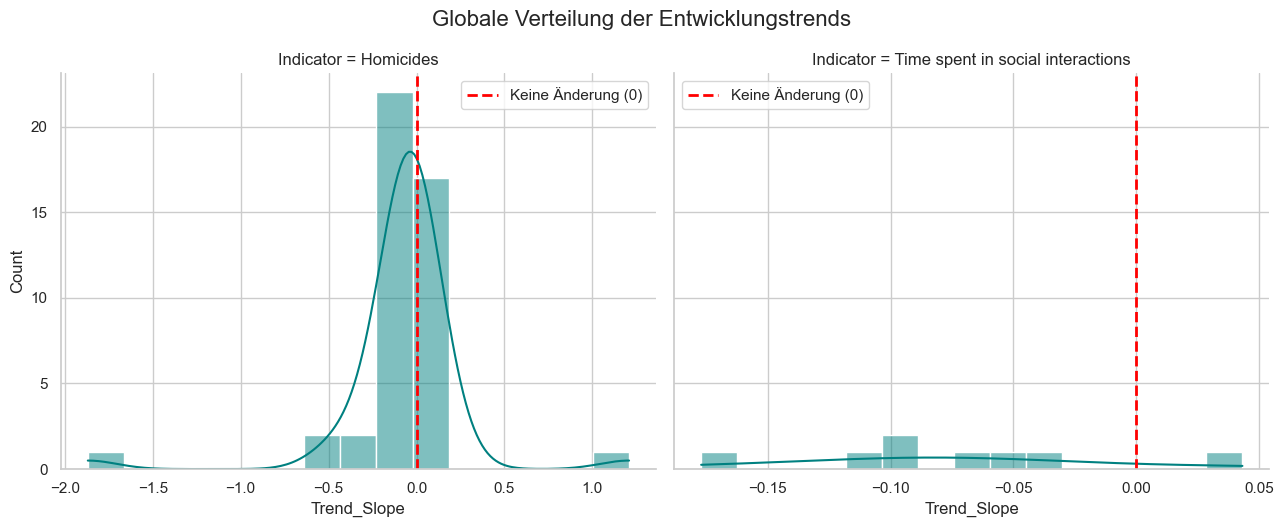

In [8]:
g = sns.FacetGrid(trend_results, col="Indicator", sharex=False, height=5, aspect=1.3)
g.map(sns.histplot, "Trend_Slope", kde=True, bins=15, color='teal')

# Referenzlinie bei 0 einfügen
for ax in g.axes.flat:
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Keine Änderung (0)')
    ax.legend()
    
g.fig.suptitle('Globale Verteilung der Entwicklungstrends', fontsize=16, y=1.05)
plt.show()

## Interpretation der globalen Verteilung der Trends

Die beiden Histogramme zeigen, wie sich die **geschätzten Steigungen (Trend_Slope)** über alle Länder verteilen. Die rote, gestrichelte Linie markiert jeweils „keine Veränderung“ (Steigung = 0).

#### Homicides

Links sehen wir die Verteilung der Trends für die Mordrate:

- Die meisten Balken liegen **links von 0**. Das heißt:  
  In der Mehrzahl der Länder ist die Steigung **negativ** → die Mordrate geht im Durchschnitt **zurück**.
- Der Schwerpunkt der Verteilung liegt grob im Bereich **zwischen ca. −0.2 und 0**.  
  Das bedeutet: In vielen Ländern sinkt die Mordrate jedes Jahr ein bisschen, aber nicht dramatisch stark.
- Es gibt einzelne **Ausreißer** mit sehr starken negativen oder positiven Steigungen  
  (z. B. Länder mit stark sinkenden oder leider auch deutlich steigenden Mordraten).  
  Diese Länder sind wichtig für die Detailanalyse, aber sie verändern den globalen Eindruck nicht:  
  insgesamt dominiert ein **Rückgang**.

*Kurz gesagt:*
Global gesehen sind die Mordraten in den meisten analysierten Ländern **tendenziell rückläufig**.

---

#### Time spent in social interactions

Rechts sehen wir die Trends für die Zeit, die Menschen im Durchschnitt in sozialen Interaktionen verbringen:

- Hier liegen fast alle Balken **unterhalb von 0**.  
  Das bedeutet: In fast allen Ländern, für die wir Daten haben, ist die Steigung **negativ** → die Zeit für soziale Kontakte **nimmt ab**.
- Die Werte sind relativ eng beieinander (keine extremen Ausreißer wie bei Homicides).  
  Das spricht dafür, dass der Rückgang zwar nicht riesig, aber recht **gleichmäßig** ist.
- Gleichzeitig sehen wir, dass es insgesamt **weniger Datenpunkte** gibt als bei den Mordraten  
  (also weniger Länder mit Zeitverlauf). Diese Aussage gilt daher nur für die Länder, die hier tatsächlich im Datensatz vertreten sind.

Damit ergibt sich ein spannendes Bild:

- **Objektive Sicherheit** (Mordrate) verbessert sich in vielen Ländern.  
- **Soziale Kontakte** werden im Durchschnitt eher **weniger**, nicht mehr.

Das ist genau die Art Gegensatz, die wir mit der Zeitreihenanalyse sichtbar machen wollten.


*Die globale Betrachtung zeigt also zwei unterschiedliche Geschichten:*
Während sich objektive Sicherheitsindikatoren wie die Mordrate in vielen Ländern verbessern, entwickeln sich soziale Aspekte wie die Zeit für zwischenmenschliche Interaktionen eher negativ.  

Damit haben wir nun sowohl die **individuellen Trends pro Land** als auch das **globale Muster** verstanden.  

Im letzten Schritt fassen wir diese Erkenntnisse zusammen und ordnen ein, was diese Trends für das Wohlbefinden der Bevölkerung bedeuten könnten.


## Fazit zu Notebook 6: Die zeitliche Dynamik

In diesem Notebook haben wir die statische "Momentaufnahme" der vorherigen Analysen verlassen und die Dimension der Zeit integriert. Durch die Anwendung linearer Regressionsmodelle auf die Zeitreihen (Year vs. Value) konnten wir nicht nur visuell, sondern auch quantitativ bestimmen, in welche Richtung sich die Länder entwickeln.

In diesem Notebook haben wir bewusst **deskriptiv** gearbeitet. Wir beschreiben Trends, **ohne daraus Kausalitäten abzuleiten** oder formale Signifikanztests auf die Trends durchzuführen.

**Spezifische Erkenntnisse der Zeitreihenanalyse:**

- **Positive Entwicklung der objektiven Sicherheit:** Ein Großteil der untersuchten OECD-Länder weist einen negativen Trend-Slope bei der Mordrate auf. Das bedeutet mathematisch, dass die Kurve nach unten zeigt und die Anzahl der Tötungsdelikte über die Jahre gesunken ist. Dies ist ein starker Indikator für eine Verbesserung der objektiven Sicherheitslage.

- **Stabilität sozialer Strukturen:** Beim Indikator Social Support sind die Steigungen (Slopes) oft flacher oder stagnierend. Dies deutet darauf hin, dass soziale Netzwerke und Unterstützungssysteme träger sind und sich langsamer verändern als Kriminalitätsraten.

- **Heterogenität der Länder:** Die Analyse zeigt deutlich, dass es keinen universalen globalen Pfad gibt. Während einige Länder (siehe "Verbesserer"-Listen) enorme Fortschritte machten, kämpfen andere mit Stagnation. Dies unterstreicht die Wichtigkeit, Daten nicht nur aggregiert (als Weltdurchschnitt), sondern länderspezifisch zu betrachten.

**Methodische Reflexion:** Wir haben eine lineare Entwicklung angenommen (y=mx+b). Dies ist eine nützliche Vereinfachung, um den generellen Trend zu erkennen. In der Realität verlaufen gesellschaftliche Entwicklungen jedoch oft wellenförmig oder sprunghaft, was durch komplexere Modelle (die hier den Rahmen sprengen würden) noch detaillierter abgebildet werden könnte.

## Gesamtfazit und Projekt-Rückblick: Determinanten des Sicherheitsgefühls

Mit diesem Notebook schließen wir unsere statistische Untersuchung der OECD "Better Life"-Daten ab. Unser Ziel war es, zu verstehen, was das Sicherheitsgefühl ("Feeling Safe") von Menschen beeinflusst. Wir sind dabei einem klaren "Roten Faden" gefolgt, der deskriptive, induktive und explorative Statistik verknüpft.

**Der "Rote Faden" unserer Analyse (Notebook 01–06):**

- **Datenbasis (NB 01 & 02):** Wir begannen mit der Bereinigung und Inspektion. Wir lernten, dass Daten oft ungleich verteilt sind und Ausreißer (wie extrem hohe Mordraten in wenigen Ländern) die Statistik verzerren können, weshalb wir oft logarithmische Transformationen oder robuste Tests nutzen mussten.

- **Bivariate Zusammenhänge (NB 03):** Die Korrelationsanalyse gab uns die ersten Hinweise: Es besteht ein starker Zusammenhang zwischen objektiver Gefahr (Mordrate) und subjektivem Gefühl. Doch überraschend stark war auch der Zusammenhang mit Social Support: wer sich sozial eingebettet fühlt, fühlt sich oft auch sicherer.

- **Signifikanz (NB 04):** Wir haben nicht nur vermutet, sondern bewiesen. Die Gruppenvergleiche zeigten, dass Länder mit hohem sozialen Support ein statistisch signifikant höheres Sicherheitsgefühl aufweisen als Länder mit niedrigem Support.

- **Modellierung (NB 05):** Das Herzstück der Analyse war das multiple Regressionsmodell. Wir konnten zeigen, dass ca. 50% der Unterschiede im Sicherheitsgefühl allein durch zwei Faktoren erklärt werden können: die objektive Kriminalität (Log_Homicides) und den sozialen Zusammenhalt (Social Support). Das bedeutet: Sicherheit ist zur Hälfte "Fakt" und zur Hälfte "soziales Gefühl".

- **Dynamik (NB 06):** Zum Abschluss zeigte die Zeitreihenanalyse, dass die objektiven Grundlagen (sinkende Mordraten) in vielen Ländern besser werden, was Hoffnung gibt, dass langfristig auch das Sicherheitsgefühl folgen könnte.


**Abschließende Bewertung**

Dieses Projekt zeigt die Kraft der Statistik: Sie erlaubt uns, über das reine "Bauchgefühl" hinauszublicken. Wir haben gezeigt, dass Sicherheit kein Zufallsprodukt ist, sondern messbaren, politischen und gesellschaftlichen Faktoren folgt. Wer das Sicherheitsgefühl der Bevölkerung steigern will, darf nicht nur Kriminalität bekämpfen, sondern muss auch den sozialen Zusammenhalt stärken.